In [1]:
!pip install newsapi-python

In [2]:
!pip install transformers

In [3]:
from newsapi import NewsApiClient
import pandas as pd
import re
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
# Initialize News API client
api_key = 'yourkey'  # Replace with your News API key
newsapi = NewsApiClient(api_key=api_key)


query = "jaguar rebrand"
from_date = "2024-11-20"
to_date = "2024-11-24"

# Get articles
articles = newsapi.get_everything(
    q=query,
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page_size=100
)

news_data = []
for article in articles['articles']:
    news_data.append({
        'source': article['source']['name'],
        'author': article['author'],
        'title': article['title'],
        'description': article['description'],
        'content': article['content'],
        'published_at': article['publishedAt']
    })

df = pd.DataFrame(news_data)

df.to_csv('jaguvar_news.csv', index=False)
print(df.head())


               source                          author  \
0              Dezeen                 Tom Ravenscroft   
1           HYPEBEAST  info@hypebeast.com (Hypebeast)   
2            Jalopnik                   Owen Bellwood   
3  Al Jazeera English                       Erin Hale   
4       Creative Bloq                     Daniel John   

                                               title  \
0  This week we revealed Jaguar's new brand identity   
1  Jaguar Unveils Brand Overhaul to Mark All-Elec...   
2   What’s The Worst Automotive Rebrand Of All Time?   
3  ‘Do you sell cars?’: Jaguar’s rebrand prompts ...   
4  ‘It completely misunderstands what a brand is’...   

                                         description  \
0  This week on Dezeen, British car brand Jaguar ...   
1  This week Jaguar unveiled its forthcoming rebr...   
2  I don’t know if you saw the news this week, bu...   
3  British luxury automaker's advertising campaig...   
4  We talk to JKR’s Lee Rolston about th

In [5]:
# Fill missing values with an empty string
df.fillna("", inplace=True)

# Concatenate title, description, and content into a single column
df['text'] = df['title'] + " " + df['description'] + " " + df['content']

# Remove duplicates based on the concatenated text
df.drop_duplicates(subset=['text'], inplace=True)

# Clean text: remove URLs, special characters, and multiple spaces
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

df['clean_text'] = df['text'].map(clean_text)


df.to_csv('jaguvar_news_preprocessed.csv', index=False)
print(df[['clean_text', 'published_at']].head())


                                          clean_text          published_at
0  This week we revealed Jaguars new brand identi...  2024-11-23T06:00:46Z
1  Jaguar Unveils Brand Overhaul to Mark AllElect...  2024-11-22T16:11:38Z
2  Whats The Worst Automotive Rebrand Of All Time...  2024-11-22T14:15:00Z
3  Do you sell cars Jaguars rebrand prompts mocke...  2024-11-21T06:10:03Z
4  It completely misunderstands what a brand is A...  2024-11-21T12:05:46Z


In [6]:
sentiment_analyzer = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment')

def analyze_sentiment_transformer(text):
    result = sentiment_analyzer(text[:512])
    sentiment = result[0]
    label_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}
    return label_map[sentiment['label']], sentiment['score']

df['sentiment'], df['sentiment_score'] = zip(*df['clean_text'].map(analyze_sentiment_transformer))

df.to_csv('jaguvar_sentiment.csv', index=False)

print(df[['clean_text', 'sentiment', 'sentiment_score']].head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

                                          clean_text sentiment  \
0  This week we revealed Jaguars new brand identi...   Neutral   
1  Jaguar Unveils Brand Overhaul to Mark AllElect...   Neutral   
2  Whats The Worst Automotive Rebrand Of All Time...  Positive   
3  Do you sell cars Jaguars rebrand prompts mocke...  Negative   
4  It completely misunderstands what a brand is A...   Neutral   

   sentiment_score  
0         0.761533  
1         0.653066  
2         0.564170  
3         0.630759  
4         0.520533  


<ipython-input-7-a4dcf139006f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='coolwarm', order=['Negative', 'Neutral', 'Positive'])


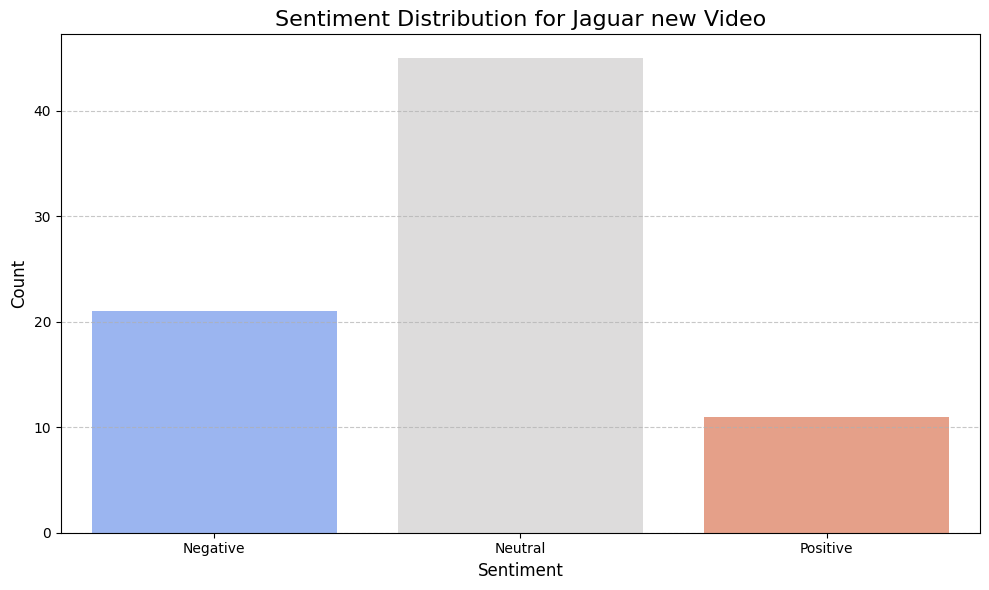

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', palette='coolwarm', order=['Negative', 'Neutral', 'Positive'])
plt.title('Sentiment Distribution for Jaguar new Video', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

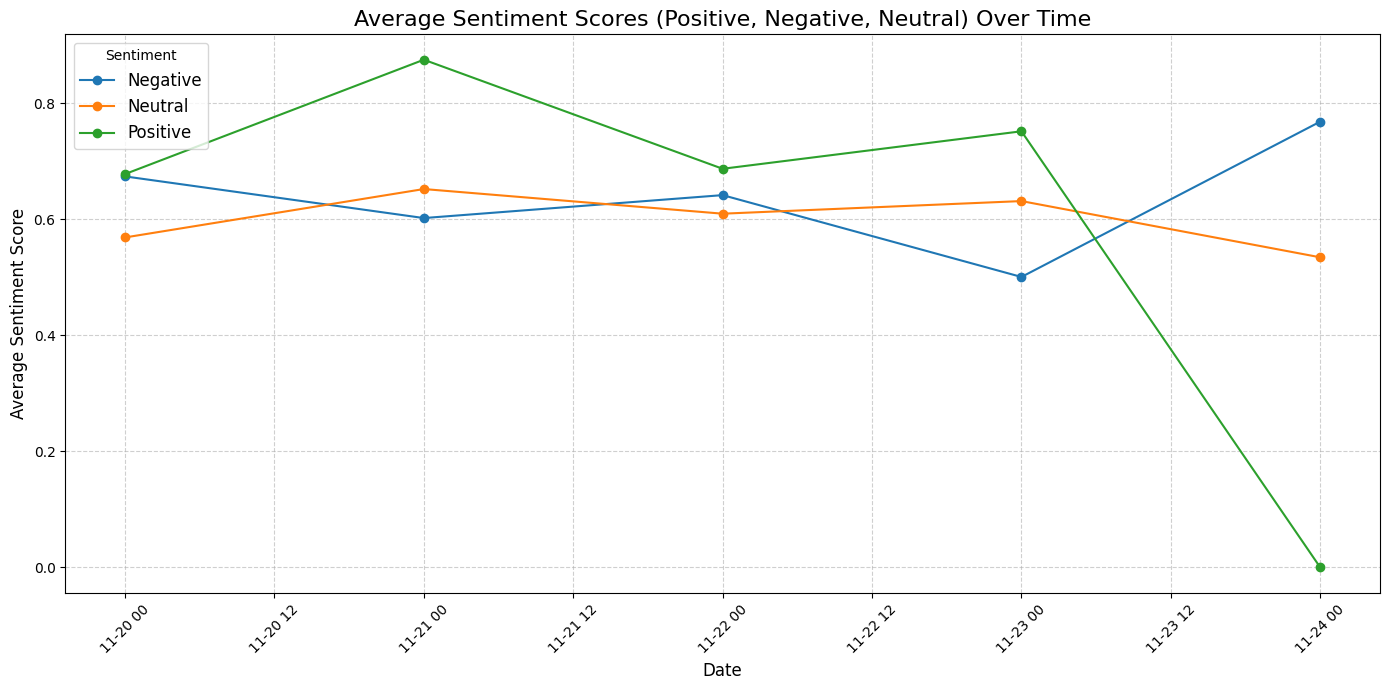

In [8]:
df['date'] = pd.to_datetime(df['published_at'], errors='coerce')


df['date'] = df['date'].dt.date

# Group by date and sentiment, and calculate the average sentiment score
average_sentiment_scores = df.groupby(['date', 'sentiment'])['sentiment_score'].mean().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
average_sentiment_scores.plot(kind='line', marker='o', linestyle='-', markersize=6, figsize=(14, 7))
plt.title('Average Sentiment Scores (Positive, Negative, Neutral) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Sentiment', loc='upper left', fontsize=12)
plt.show()


In [9]:
emotion_analyzer = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base')

def analyze_emotion(text):
    result = emotion_analyzer(text[:512])
    emotion = result[0]
    return emotion['label'], emotion['score']

df['emotion'], df['emotion_score'] = zip(*df['clean_text'].map(analyze_emotion))

df.to_csv('jaguvar_emotion.csv', index=False)

print(df[['clean_text', 'emotion', 'emotion_score']].head())


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

                                          clean_text  emotion  emotion_score
0  This week we revealed Jaguars new brand identi...  neutral       0.765754
1  Jaguar Unveils Brand Overhaul to Mark AllElect...      joy       0.793510
2  Whats The Worst Automotive Rebrand Of All Time...  disgust       0.593902
3  Do you sell cars Jaguars rebrand prompts mocke...  neutral       0.413878
4  It completely misunderstands what a brand is A...  neutral       0.697433


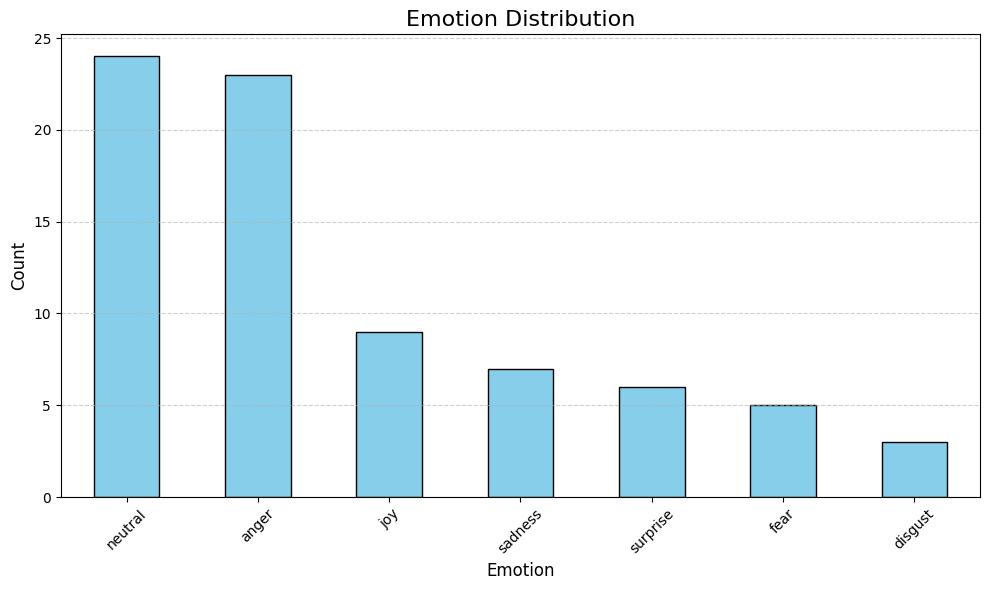

In [10]:
emotion_counts = df['emotion'].value_counts()

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Emotion Distribution', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

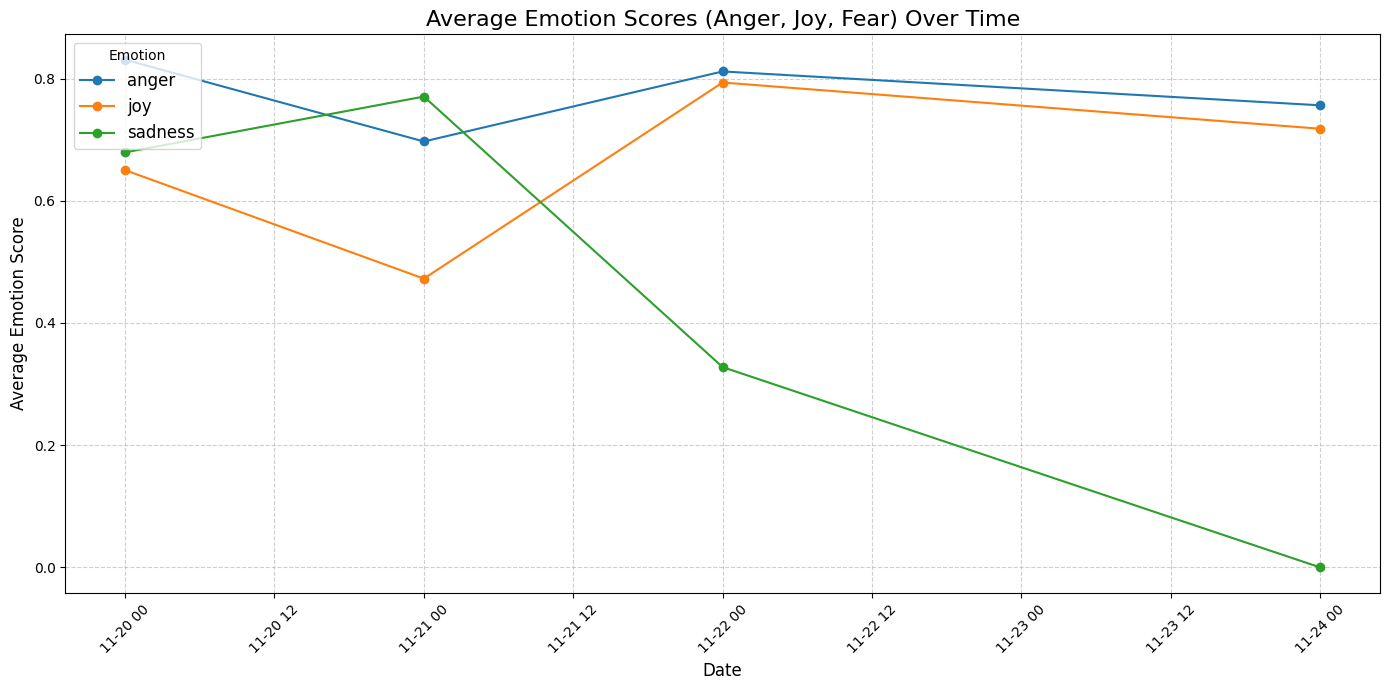

In [15]:
filtered_emotions = df[df['emotion'].isin(['anger', 'joy', 'sadness'])]

average_emotion_scores = filtered_emotions.groupby(['date', 'emotion'])['emotion_score'].mean().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
average_emotion_scores.plot(kind='line', marker='o', figsize=(14, 7), linestyle='-', markersize=6)
plt.title('Average Emotion Scores (Anger, Joy, Fear) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Emotion Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Emotion', loc='upper left', fontsize=12)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


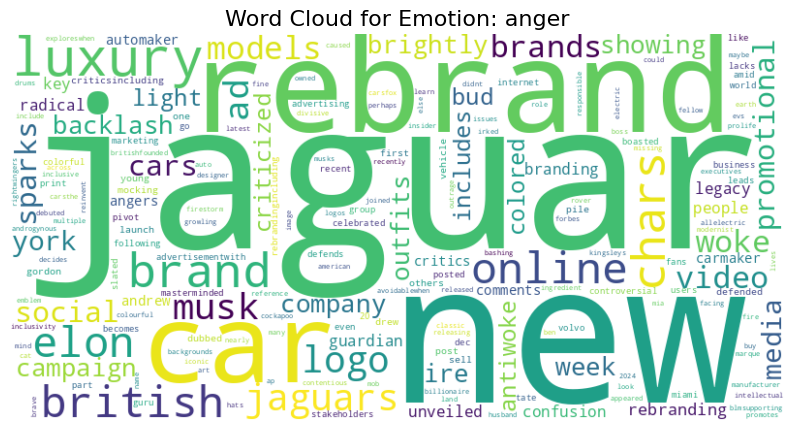

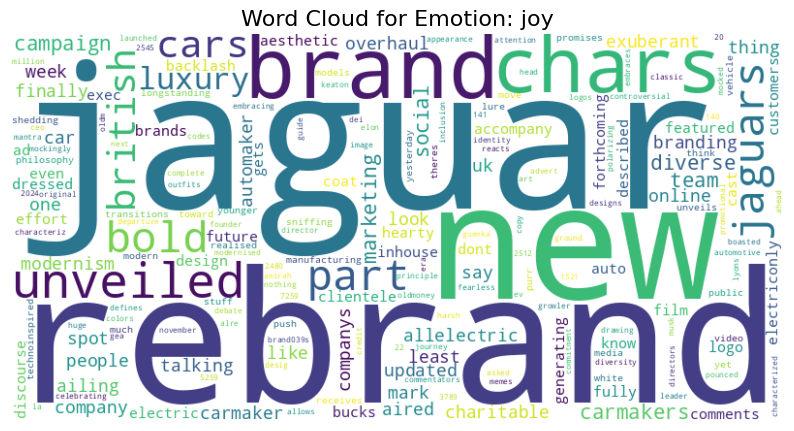

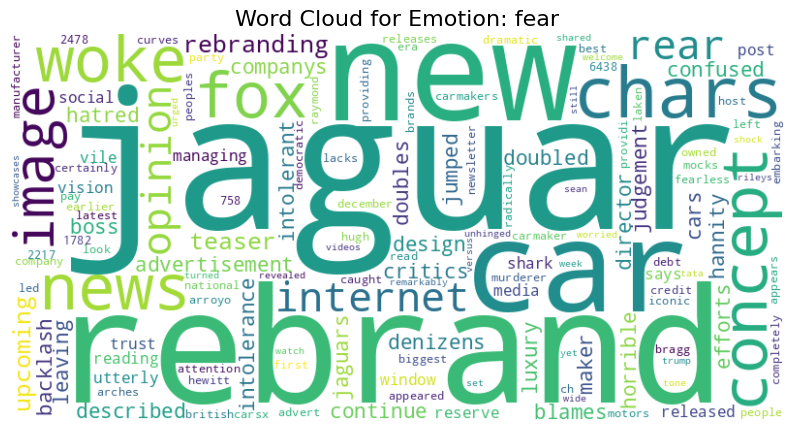

In [12]:
# Download stopwords if not already available
import nltk
nltk.download('stopwords')

# Define a function to generate word cloud for a given emotion
def plot_wordcloud(emotion, text_data):
    # Set up the CountVectorizer to exclude stopwords
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    # Fit the vectorizer and transform the text
    X = vectorizer.fit_transform(text_data)
    # Sum up the word frequencies
    word_freq = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()

    # Create a dictionary of words and their frequencies
    word_freq_dict = dict(zip(words, word_freq))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Emotion: {emotion}", fontsize=16)
    plt.show()

# Filter the dataframe to exclude neutral emotions
filtered_emotions = df[df['emotion'] != 'neutral']

# Loop over each emotion and generate the word cloud
for emotion in ['anger', 'joy', 'fear']:
    emotion_data = filtered_emotions[filtered_emotions['emotion'] == emotion]['clean_text']
    plot_wordcloud(emotion, emotion_data)


In [13]:
# Function to get the most common bigrams for a given emotion
def extract_bigrams_by_emotion(df, emotion):
    # Filter the data for the specific emotion
    emotion_df = df[df['emotion'] == emotion]

    # Initialize vectorizer to capture common bigrams (pairs of words)
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")

    # Apply vectorizer to extract bigrams
    X = vectorizer.fit_transform(emotion_df['clean_text'])  # Ensure you are using the 'clean_text' column
    bigrams = vectorizer.get_feature_names_out()
    bigram_counts = X.toarray().sum(axis=0)

    # Create a DataFrame to store bigrams and their counts
    bigram_freq_df = pd.DataFrame({'Bigram': bigrams, 'Frequency': bigram_counts})
    bigram_freq_df = bigram_freq_df.sort_values(by='Frequency', ascending=False)

    return bigram_freq_df

# Extract and save the most common bigrams to separate CSV files for each emotion
emotions = ['anger', 'joy', 'sadness']

# Loop through each emotion and save the bigrams to a CSV
for emotion in emotions:
    # Extract bigrams for the current emotion
    bigram_freq_df = extract_bigrams_by_emotion(df, emotion)

    # Save the bigrams and their frequencies to a CSV file named after the emotion
    file_name = f'{emotion}_bigrams.csv'
    bigram_freq_df.to_csv(file_name, index=False)  # Save both 'Bigram' and 'Frequency' columns

    # Display the saved CSV content
    print(f"Displaying top bigrams for {emotion.capitalize()} from {file_name}:")
    print(bigram_freq_df.head(40))
    print("\n" + "-"*50 + "\n")


Displaying top bigrams for Anger from anger_bigrams.csv:
                        Bigram  Frequency
435                   new logo         14
373                 luxury car         14
218                  elon musk         14
309             jaguar rebrand         14
107             british luxury         12
122                  car brand         12
87                brand jaguar         10
574               social media          8
491          promotional video          8
406            models brightly          7
456             online showing          7
505            rebrand british          7
626              video rebrand          7
568             showing models          7
444                   new york          7
296          jaguar criticized          6
103           brightly colored          6
110                  bud light          6
156            colored outfits          6
457                outfits car          6
185          criticized online          6
512           rebra

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# List of file paths for the CSV files
file_paths = [
    "/content/jaguvar_emotion.csv",
    "/content/sadness_bigrams.csv",
    "/content/joy_bigrams.csv",
    "/content/anger_bigrams.csv"
]

# Read CSV files
dataframes = [pd.read_csv(file) for file in file_paths]

# Combine the DataFrames
combined_df = pd.concat(dataframes, axis=1)  # Use axis=1 for column-wise or axis=0 for row-wise concatenation

# Save combined DataFrame to a new Excel file
combined_df.to_excel("combined_output.xlsx", index=False, engine='openpyxl')  # Ensure 'openpyxl' is installed

print("Data combined and saved to 'combined_output.xlsx'.")
